In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt 

np.random.seed(42)

In [2]:
def softmax(logits):
    exp_logits = np.exp(logits - np.max(logits, axis=1, keepdims=True))  
    return exp_logits / np.sum(exp_logits, axis=1, keepdims=True)

def mcce(softmax_logits, labels):
    return - np.sum(labels * np.log(softmax_logits))

def sigmoid(unactivated):
    return 1 / (1 + np.exp(-unactivated))

def sigmoid_derivative(activated):
    return sigmoid(activated) * (1 - sigmoid(activated))

def relu(unactivated):
    return np.maximum(0, unactivated)

def relu_derivative(activated):
    return (activated > 0).astype(float)

In [3]:
arr = [[-2, 3, 2]]
sm = softmax(arr)
sm, sum(sm[0]), mcce(sm, [[0, 0, 1]]), mcce(sm, [[1, 0, 0]]), mcce(sm, [[0, 1, 0]])

(array([[0.00490169, 0.72747516, 0.26762315]]),
 np.float64(1.0),
 np.float64(1.318175429247454),
 np.float64(5.318175429247454),
 np.float64(0.31817542924745396))

In [4]:
class model:
    def __init__(self, input_size=2, hidden_size=64, output_size=2):
        shape_i_h = (input_size, hidden_size)
        shape_h_o = (hidden_size, output_size)

        self.w_i_h = np.random.normal(loc=0.0, scale=1.0, size=shape_i_h) # randomly sample unique weights from a gaussian dist with mean 0 and std 1
        self.w_h_o = np.random.normal(loc=0.0, scale=1.0, size=shape_h_o) # randomly sample unique weights from a gaussian dist with mean 0 and std 1

        self.b_i_h = np.zeros(shape=(1, hidden_size)) # set biases to zero
        self.b_h_o = np.zeros(shape=(1, output_size)) # set biases to zero

        self.num_params = input_size * hidden_size + hidden_size * output_size + hidden_size + output_size

    def forward(self, features, train=False):
        forward_results = {}

        forward_results['features'] = features
        i_h = features @ self.w_i_h
        forward_results['i_h'] = i_h
        i_h_b = i_h + self.b_i_h
        forward_results['i_h_b'] = i_h_b
        a_i_h_b = relu(i_h_b)
        forward_results['a_i_h_b'] = a_i_h_b        

        h_o = a_i_h_b @ self.w_h_o
        forward_results['h_o'] = h_o        
        h_o_b = h_o + self.b_h_o
        forward_results['h_o_b'] = h_o_b
        a_h_o_b = softmax(h_o_b)
        forward_results['a_h_o_b'] = a_h_o_b

        if train:
            return a_h_o_b, forward_results
        return a_h_o_b

    def backward(self, forward_results, labels):
        gradients = {}
        
        probs = forward_results['a_h_o_b']
        
        dL_dh_o_b = probs - labels
        
        a_i_h_b = forward_results['a_i_h_b']
        gradients['w_h_o'] = a_i_h_b.T @ dL_dh_o_b
        gradients['b_h_o'] = np.sum(dL_dh_o_b, axis=0, keepdims=True)

        dL_da_i_h_b = dL_dh_o_b @ self.w_h_o.T 
        dL_di_h_b = dL_da_i_h_b * relu_derivative(forward_results['a_i_h_b'])

        gradients['w_i_h'] = forward_results['features'].T @ dL_di_h_b 
        gradients['b_i_h'] = np.sum(dL_di_h_b, axis=0, keepdims=True)

        return gradients
        
    def update_weights(self, gradients, learning_rate):
        self.w_h_o -= (learning_rate * gradients['w_h_o'])
        self.b_h_o -= (learning_rate * gradients['b_h_o'])
        self.w_i_h -= (learning_rate * gradients['w_i_h'])
        self.b_i_h -= (learning_rate * gradients['b_i_h'])

    def train(self, features, labels, valid_features, valid_labels, num_epochs, learning_rate):
        train_loss = []
        valid_loss = []
        
        for i in range(num_epochs):
            probs, forward_results = self.forward(features, train=True)
            
            gradients = self.backward(forward_results, labels)
            # for k, v in gradients.items():
            #     print(f'{k}: {v.shape}')
            
            self.update_weights(gradients, learning_rate)
            
            loss = mcce(forward_results['a_h_o_b'], labels)
            train_loss.append(loss)

            probs, forward_results = self.forward(valid_features, train=True)
                                    
            loss = mcce(forward_results['a_h_o_b'], valid_labels)
            valid_loss.append(loss)
        
        return train_loss, valid_loss
    
    def predict(self, features):
        y_predicted = self.forward(features)
        predicted_labels = np.array([np.argmax(y_p) for y_p in y_predicted])
        return predicted_labels


In [5]:
i = np.ones((1, 2))
i_multiple = np.ones((16, 2))

In [6]:
m = model()
m.forward(i), m.forward(i_multiple).shape

(array([[5.51802409e-14, 1.00000000e+00]]), (16, 2))

In [7]:
_, results = m.forward(i_multiple, True)
m.backward(results, np.ones((16, 2)))

{'w_h_o': array([[-2.09478396e+01, -1.15818734e-12],
        [-1.94876116e+01, -1.07745264e-12],
        [-9.21085466e+00, -5.09259926e-13],
        [-4.04250041e+01, -2.23506236e-12],
        [-2.03972241e+00, -1.12774430e-13],
        [ 0.00000000e+00,  0.00000000e+00],
        [-3.10497347e+01, -1.71671209e-12],
        [-3.68875407e+01, -2.03947917e-12],
        [ 0.00000000e+00,  0.00000000e+00],
        [-3.37152592e+01, -1.86408656e-12],
        [ 0.00000000e+00,  0.00000000e+00],
        [-5.69876401e+00, -3.15079571e-13],
        [-5.26414944e+00, -2.91050120e-13],
        [ 0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00],
        [-1.07417585e+01, -5.93902229e-13],
        [-9.11791951e+00, -5.04121624e-13],
        [ 0.00000000e+00,  0.00000000e+00],
        [-1.05144827e+01, -5.81336353e-13],
        [ 0.00000000e+00,  0.00000000e+00],
        [-1.57268852e+0

In [8]:
# csv_file_prefix = 'spiral'
# csv_file_prefix = 'two_gaussians'
csv_file_prefix = 'xor'
# csv_file_prefix = 'center_surround'

In [9]:
def z_score(df, scaler):
    features = df.iloc[:, 1:]
    labels = df.iloc[:, 0]

    features = scaler.transform(features)
    num_labels = len(np.unique(labels))
    labels = np.array([[1 if int(label) == i else 0 for i in range(num_labels)] for label in labels])
    return features, labels

In [10]:
scaler = StandardScaler()  # z-score all input features

train_df = pd.read_csv(f'{csv_file_prefix}_train.csv')

train_features = train_df.iloc[:, 1:]
features = scaler.fit(train_features)

valid_df = pd.read_csv(f'{csv_file_prefix}_valid.csv')
test_df = pd.read_csv(f'{csv_file_prefix}_test.csv')

train_features, train_labels = z_score(train_df, scaler)
valid_features, valid_labels = z_score(valid_df, scaler)
test_features, test_labels = z_score(test_df, scaler)

In [11]:
train_features

array([[-7.70456523e-01,  8.76493383e-01],
       [ 7.06498327e-01,  2.66823092e-02],
       [-4.56966795e-01, -1.66068960e+00],
       [ 1.68092581e+00, -1.68531209e-01],
       [-3.96545074e-01, -1.35917560e+00],
       [-1.33322055e+00, -1.18451087e+00],
       [-1.75862370e-01,  6.91257884e-01],
       [-6.22362236e-02,  5.17778665e-01],
       [-1.72748847e+00, -1.47515772e+00],
       [ 8.49271246e-01,  1.25111366e+00],
       [-1.04711954e+00,  1.80711653e+00],
       [-2.73851043e-01,  9.60170433e-01],
       [-1.17198708e-01,  7.72069958e-01],
       [ 1.47597311e+00, -5.34382187e-02],
       [-1.54488071e-01,  1.93716815e-02],
       [ 1.03007376e+00, -6.83535293e-01],
       [-8.63726194e-01, -4.66291099e-01],
       [ 1.03627323e+00,  1.16911608e+00],
       [-1.39358583e-02,  1.66870857e+00],
       [ 6.97245383e-01,  1.46312186e+00],
       [-1.07298059e-01,  9.51453497e-02],
       [ 1.30044477e+00, -4.50583129e-01],
       [ 8.88133608e-01, -1.18470846e+00],
       [-1.

In [12]:
train_labels

array([[1, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [1, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [1, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [1, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [0,

In [13]:
m = model(input_size=2, hidden_size=9, output_size=2)

num_epochs = 1000
learning_rate = 0.001
train_loss, valid_loss = m.train(train_features, train_labels, valid_features, valid_labels, num_epochs, learning_rate)

In [14]:
test_results = m.predict(test_features)
np.sum([1 for i, t_l in enumerate(test_labels) if np.argmax(t_l) == test_results[i]]) / len(test_labels)

np.float64(0.995)

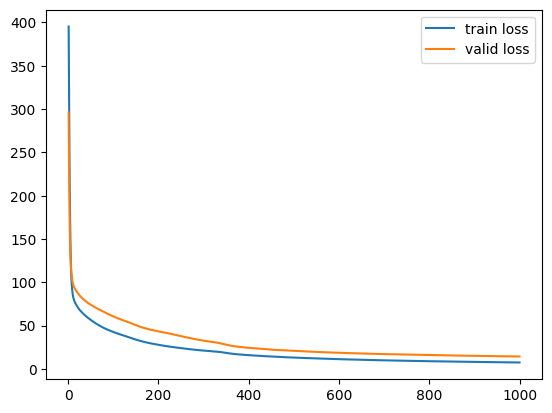

In [15]:
plt.plot(range(1, num_epochs + 1), train_loss, label='train loss')
plt.plot(range(1, num_epochs + 1), valid_loss, label='valid loss')
plt.legend()

plt.show()

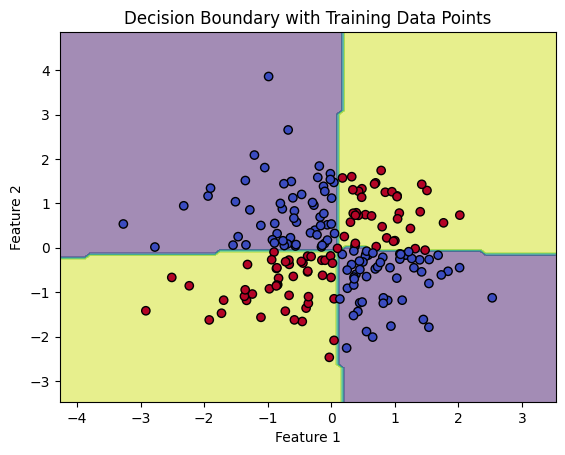

In [16]:
x_min, x_max = train_features[:, 0].min() - 1, train_features[:, 0].max() + 1
y_min, y_max = train_features[:, 1].min() - 1, train_features[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

# Predict labels for all points in the meshgrid
grid_points = np.c_[xx.ravel(), yy.ravel()]
Z = m.predict(grid_points)
Z = Z.reshape(xx.shape)

# Plot decision boundary
plt.contourf(xx, yy, Z, alpha=0.5, cmap='viridis')

# Scatter plot of training points
plt.scatter(train_features[:, 0], train_features[:, 1], c=np.array([np.argmax(l) for l in train_labels]), edgecolor='k', cmap='coolwarm', marker='o')

plt.title("Decision Boundary with Training Data Points")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

In [17]:
m.w_i_h

array([[ 1.05249539,  1.17834718,  1.12541797,  1.31292019, -1.91880409,
        -1.81854452, -3.79828783, -1.57585666, -0.35174842],
       [-1.03181689,  2.58077688, -3.04996153,  0.66923924,  0.96382384,
         1.00254408, -2.92347977,  0.85830566,  0.15667999]])

In [18]:
m.b_i_h

array([[-0.1448483 , -0.23141454, -0.15497174, -0.28337804,  0.19990375,
         0.19134776,  0.17155459,  0.16545807,  0.03639136]])